Import necessary library

In [1]:

from xml.dom import minidom
import re
import numpy as np
# https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt


In [2]:

# from nltk.corpus import stopwords
# stopwords.words('english')

Data Cleaning Functions

In [3]:

TAG_RE = re.compile(r'<[^>]+>|\'')
def remove_tags(text):
    return TAG_RE.sub('', text)

PUNC_TAG = re.compile(r'[^a-zA-Z0-9]')
def remove_punctuation(text):
    return PUNC_TAG.sub(' ', text)

Spaces = re.compile(r'  *')
def remove_spaces(text):
    return Spaces.sub(' ', text)

def remove_junk(string):
    return (remove_spaces(remove_punctuation(remove_tags(string)))).lower()


loading stop words in a list

In [4]:

# https://github.com/Alir3z4/stop-words/blob/master/english.txt
file = open('english.txt', 'r')
stopwords = []

for i in file.readlines():
    i = i.split()
    stopwords = stopwords + i

file.close()
# other stopwords collections
# https://streamhacker.com/2010/05/24/text-classification-sentiment-analysis-stopwords-collocations/

<h5>Word Stemming and Lemmatization Functions</h5>
<a href="https://gist.github.com/mmmayo13/07252b4eb27e5495b6032888b38e5333#file-text_data_preprocessing_5-py" target="_blank">more on this link</a>

In [5]:

# https://gist.github.com/mmmayo13/07252b4eb27e5495b6032888b38e5333#file-text_data_preprocessing_5-py
def stem_word(word):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()   
    return stemmer.stem(word)

def lemmatize_verb(word):
    """Lemmatize verbs"""
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word, pos='v')

def lemm(word):
    """Lemmatize nouns"""
    wordnet_lemmatizer = WordNetLemmatizer()
    return wordnet_lemmatizer.lemmatize(word)

def pot(word):
    porter_stemmer = PorterStemmer()
    return porter_stemmer.stem(word)


In [6]:
def build_wordlist(filelocation, stopwords, wordmap, index, MAX_ROWS = 200):

    # parse an xml file by name
    mydoc = minidom.parse(filelocation)
    
    # get each row in the file
    items = mydoc.getElementsByTagName('row')
    count=0
    
    for item in items:
        
        
        # remove unnecessary things
        string = remove_junk(item.attributes['Body'].value)
        
        # not count a paragraph without any value
        if len(string) < 2:
            continue
        
        count=count+1
        if count==MAX_ROWS:
            break
        
        # check every single words in the string
        words = string.split(" ")
        
        for word in words:
            
            # check whether it's an important word or not
            # https://docs.python.org/3/library/stdtypes.html#str.isnumeric
            if not word.isnumeric() and len(word) > 1:
                # lemmatize the words 
                word = lemm(lemmatize_verb(word))
                
                if not word.isnumeric() and word not in wordmap and word not in stopwords and len(word) > 1:
                    
                    wordmap[word] = index
                    index = index + 1

    
    return wordmap, index


In [7]:
def vectormapping(filelocation, wordmap, MAX_ROWS = 200):

    count = 0
    mainvec =[]
    
    testdoc = minidom.parse(filelocation)
    testItems = testdoc.getElementsByTagName('row')

    for testItem in testItems:
        
        
        
        # initialize the vector
        vector = [0]*len(wordmap)
        
        # okay, remove the junk as before
        string = remove_tags(testItem.attributes['Body'].value)
        string = remove_punctuation(string)
        string = remove_spaces(string)
        string = string.lower()
        
        # not count a paragraph without any value
        if len(string) < 2:
            continue
        
        count=count+1
        if count==MAX_ROWS:
            break

        # check every words in the string
        words = string.split(" ")
        
        # now go through every word
        for w in words:
            # lemmatize the word
            w = lemm(lemmatize_verb(w))
            
            # count how many times it's in the string
            if w in wordmap.keys():
                vector[wordmap[w]]=vector[wordmap[w]]+1
        
        # append this vector of a single row to the whole vector list
        mainvec.append(vector)

    return mainvec


In [8]:
# if we need the total wordmap in a list....
def features_name(wordmap):

    features = [0] * len(wordmap)

    for i in range(len(wordmap)):
            for w, c in wordmap.items():
                if i == c:
                    features[i] = w
    return features

#  WordMap 

In [9]:
filenames = open('./Dataset/topics.txt', 'r')
names = []

for i in filenames.readlines():
    names = names + i.split()

wordmap = {}
index = 0
MAX_ROWS = 200

# build the total wordMap of all the files and rows
for name in names:
    fileloc = './Dataset/Training/' + name + '.xml'
    wordmap, index = build_wordlist(fileloc, stopwords, wordmap, index, MAX_ROWS + 1)


print('wordmap generated')
print('total number of features:', len(wordmap))


wordmap generated
total number of features: 5444


In [10]:
# for w in features_name(wordmap):
#     print(w)


In [11]:
"""
# print(features_name(wordmap))
f = open('word.txt', 'w')
for w in features_name(wordmap):
    if len(w) < 4:
        f.write(w + '\n')
"""

"\n# print(features_name(wordmap))\nf = open('word.txt', 'w')\nfor w in features_name(wordmap):\n    if len(w) < 4:\n        f.write(w + '\n')\n"

## Vector Mapping for Training Data


In [12]:

total_vector = []

# create a list of vectors of all the training datasets
for name in names:
    fileloc = './Dataset/Training/' + name + '.xml'
    print('>>', name, end='--')
    total_vector = total_vector + vectormapping(fileloc, wordmap, MAX_ROWS + 1)
    print('Done')

total_vector = np.array(total_vector)

>> Anime--Done
>> Coffee--Done
>> Cooking--Done
>> Wood_Working--Done


In [13]:

print('total number of features in wordMap:', end=' ')
print(len(total_vector[0]))
print('training vectors of total rows:', end=' ')
print(len(total_vector[:,0]))
features = features_name(wordmap)
for i in np.argsort(-total_vector.sum(axis=0))[:10]:
    print(features[i], total_vector.sum(axis=0)[i])

total number of features in wordMap: 5444
training vectors of total rows: 800
coffee 584
wood 240
time 221
water 201
anime 167
cut 158
brew 137
bean 135
roast 135
caffeine 120


<h1><b><center> KNN using Euclidean Distance</b>

In [14]:

def KNN_euclidean(total_vector, test_vector, names, MAX_ROWS, KNN=1):

    # https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.subtract.html
    euclidean_distance = np.subtract(total_vector, test_vector)
    euclidean_distance = euclidean_distance ** 2

    # https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.sum.html
    euclidean_distance = euclidean_distance.sum(axis=1)
    
    # sort the indexes
    # https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.argsort.html
    row_indexes = np.argsort(euclidean_distance)[:KNN]
    
    predic = []
    for r in row_indexes:
        val = MAX_ROWS

        for i in range(0,len(names)):
            if r < val:
                predic.append(names[i])
                break
            else:
                val = val + MAX_ROWS

    b = np.unique(predic, return_counts=True)[1]
    c = np.argmax(b)
    for i in range(len(b)):
        if i != c and b[i] == b[c]:
            return predic[0]
    
    return np.unique(predic)[np.argmax(np.unique(predic, return_counts=True)[1])]


<h3>Let's try testing on one particular class</h3>

In [15]:

namet = 'Cooking'
fileloc = './Dataset/Test/' + namet + '.xml'
actual_result = namet
print('>>>>>>>>>>>>>>>>>>>', namet, '<<<<<<<<<<<<<<<<<<<')

TEST_MAX_ROWS = 5
test_vectors = []

test_vectors = test_vectors + vectormapping(fileloc, wordmap, TEST_MAX_ROWS + 1)
test_vectors = np.array(test_vectors)
for i in np.argsort(-test_vectors.sum(axis=0))[:10]:
    print(features[i], test_vectors.sum(axis=0)[i])

accurate = 0

for test_vector in test_vectors:

    predicted_result = KNN_euclidean(total_vector, test_vector, names, MAX_ROWS, 5)

    print(actual_result,"-->", predicted_result)
    if actual_result == predicted_result:
        accurate += 1

print('accuracy:', (accurate/TEST_MAX_ROWS) * 100, '%')


>>>>>>>>>>>>>>>>>>> Cooking <<<<<<<<<<<<<<<<<<<
butter 8
drink 3
cilantro 3
real 2
sausage 2
sugar 2
add 2
bring 2
alcohol 2
temperature 2
Cooking --> Cooking
Cooking --> Cooking
Cooking --> Cooking
Cooking --> Cooking
Cooking --> Cooking
accuracy: 100.0 %


# Prediction Using Testing Data

In [16]:

def actual_result_from_id(names, total_numbers, TEST_MAX_ROWS):
    val = TEST_MAX_ROWS
    for i in range(0,len(names)):
        if total_numbers < val:
            return names[i]
        
        else:
            val = val + TEST_MAX_ROWS


In [17]:

file = open('KNN euclidian report.txt', 'w')
file.write('KNN \taccuracy\n')

KNNs = [1, 3, 5]
accuracy_eu = [0, 0, 0]


for KNN in KNNs:
    
    accurate = 0
    total_numbers = 0
    TEST_MAX_ROWS = 50
    test_vectors = []

    print('KNN = ', KNN)
    file.write(str(KNN))
    
    for name in names:
        fileloc = './Dataset/Test/' + name + '.xml'
        # print('>>>', name)

        test_vectors = test_vectors + vectormapping(fileloc, wordmap, TEST_MAX_ROWS + 1)
        print('.',end='')

    test_vectors = np.array(test_vectors)

    for test_vector in test_vectors:

        predicted_result = KNN_euclidean(total_vector, test_vector, names, MAX_ROWS, KNN)

        actual_result = actual_result_from_id(names, total_numbers, TEST_MAX_ROWS)
        total_numbers +=1
        if actual_result == predicted_result:
            accurate += 1

    print('\n')
    accuracy_eu[KNN//2] = round((accurate/total_numbers) * 100, 3)
    print('-----------------------------------------------')
    print('overall accuracy using KNN_euclidean:', accuracy_eu[KNN//2], '%')
    print('-----------------------------------------------')
    
    file.write('\t'+ str(accuracy_eu[KNN//2]) + '\n')

file.close()




KNN =  1
....

-----------------------------------------------
overall accuracy using KNN_euclidean: 58.0 %
-----------------------------------------------
KNN =  3
....

-----------------------------------------------
overall accuracy using KNN_euclidean: 52.0 %
-----------------------------------------------
KNN =  5
....

-----------------------------------------------
overall accuracy using KNN_euclidean: 55.0 %
-----------------------------------------------


<h1><b><center> KNN using Hamming Distance</h1>

In [18]:
def KNN_hamming(total_vector, test_vector, names, MAX_ROWS, KNN=1):

    # https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.subtract.html
    # penalizing training vectors with very small data. This improves model accuracy massively.
    for t in range(len(total_vector)):
        if total_vector[t].sum() < 10:
            total_vector[t] = [1]*len(total_vector[t])
    
    
    hamming_distance = np.logical_xor(total_vector, test_vector).sum(axis=1)
    
    # print(hamming_distance[0])
    # sort the indexes
    # https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.argsort.html
    row_indexes = np.argsort(hamming_distance)[:KNN]
    # print(row_indexes)
    
    predic = []
    for r in row_indexes:
        val = MAX_ROWS

        for i in range(0,len(names)):
            if r < val:
                predic.append(names[i])
                break
            else:
                val = val + MAX_ROWS

    b = np.unique(predic, return_counts=True)[1]
    c = np.argmax(b)
    for i in range(len(b)):
        if i != c and b[i] == b[c]:
            return predic[0]
    
    return np.unique(predic)[np.argmax(np.unique(predic, return_counts=True)[1])]


<h3>Let's try testing on one particular class</h3>

In [19]:
namet = 'Cooking'
fileloc = './Dataset/Test/' + namet + '.xml'
actual_result = namet
print('>>>>>>>>>>>>>>>>>>>', namet, '<<<<<<<<<<<<<<<<<<<')

TEST_MAX_ROWS = 5
test_vectors = []

test_vectors = test_vectors + vectormapping(fileloc, wordmap, TEST_MAX_ROWS + 1)
test_vectors = np.array(test_vectors)

# https://stackoverflow.com/questions/45648668/convert-numpy-array-to-0-or-1
test_vectors[test_vectors > 0] = 1
total_vector[total_vector > 0] = 1

# print(test_vectors[0, 0:100])
# print(total_vector[63].sum())

accurate = 0
for test_vector in test_vectors:

    predicted_result = KNN_hamming(total_vector, test_vector, names, MAX_ROWS, 3)

    print(actual_result,"-->", predicted_result)
    if actual_result == predicted_result:
        accurate += 1

print('accuracy:', (accurate/TEST_MAX_ROWS) * 100, '%')


>>>>>>>>>>>>>>>>>>> Cooking <<<<<<<<<<<<<<<<<<<
Cooking --> Coffee
Cooking --> Cooking
Cooking --> Cooking
Cooking --> Cooking
Cooking --> Wood_Working
accuracy: 60.0 %


# Prediction Using Testing Data

In [20]:
file = open('KNN hamming report.txt', 'w')
file.write('KNN \taccuracy\n')

KNNs = [1, 3, 5]
accuracy = [0, 0, 0]

for KNN in KNNs:
    

    accurate = 0
    total_numbers = 0
    TEST_MAX_ROWS = 50
    test_vectors = []
    
    print('KNN = ', KNN)
    file.write(str(KNN))

    
    for name in names:
        fileloc = './Dataset/Test/' + name + '.xml'
        # print('>>>>>>>>>>>>>>>>>>>', name, '<<<<<<<<<<<<<<<<<')

        test_vectors = test_vectors + vectormapping(fileloc, wordmap, TEST_MAX_ROWS + 1)
        print('.', end='')

    test_vectors = np.array(test_vectors)
    test_vectors[test_vectors > 0] = 1
    total_vector[total_vector > 0] = 1



    for test_vector in test_vectors:

        predicted_result = KNN_hamming(total_vector, test_vector, names, MAX_ROWS, KNN)
        actual_result = actual_result_from_id(names, total_numbers, TEST_MAX_ROWS)

        # print(actual_result,"-->", predicted_result)
        total_numbers += 1
        if actual_result == predicted_result:
            accurate += 1

    print('\n')
    accuracy[KNN//2] = round((accurate/total_numbers) * 100, 3)
    print('-----------------------------------------------')
    print('overall accuracy using KNN_hamming:', accuracy[KNN//2], '%')
    print('-----------------------------------------------')
    file.write('\t'+ str(accuracy[KNN//2]) + '\n')

file.close()

KNN =  1
....

-----------------------------------------------
overall accuracy using KNN_hamming: 69.5 %
-----------------------------------------------
KNN =  3
....

-----------------------------------------------
overall accuracy using KNN_hamming: 74.0 %
-----------------------------------------------
KNN =  5
....

-----------------------------------------------
overall accuracy using KNN_hamming: 74.5 %
-----------------------------------------------


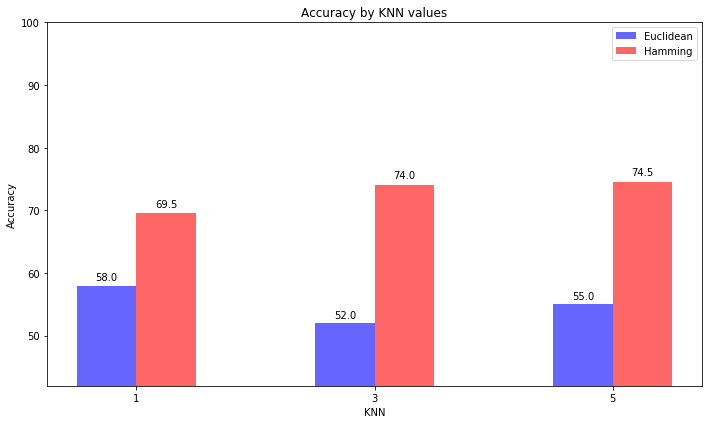

In [21]:
# create plot
fig, ax = plt.subplots(figsize=(10, 6))

# plt.grid(True)
index = np.arange(len(KNNs))
bar_width = 0.25
opacity = 0.6
 
rects1 = plt.bar(index, accuracy_eu, bar_width,
alpha=opacity,
color='b',
label='Euclidean')

plt.axis(ymin=min(accuracy_eu) - 10, ymax= 100);

rects2 = plt.bar(index + bar_width, accuracy, bar_width,
alpha=opacity,
color='r',
label='Hamming')


 
plt.xlabel('KNN')
plt.ylabel('Accuracy')
plt.title('Accuracy by KNN values')
plt.xticks(index + bar_width/2, ('1', '3', '5'))
plt.legend()


# https://matplotlib.org/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


autolabel(rects1, "center")
autolabel(rects2, "center")


plt.tight_layout()
plt.show()